In [1]:
import os
import numpy as np
import glob
from collections import defaultdict
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyproj import Geod
import pickle
import pandas as pd

# Data Import

In [2]:
path = '/glade/work/stevenxu/CESM1'
all_files = glob.glob(os.path.join(path, "*.nc"))
print(all_files) 
datasets = {}
for file in all_files:
    varname = os.path.basename(file).split("_")[0]
    datasets[varname] = xr.open_dataset(file)

['/glade/work/stevenxu/CESM1/PREC_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/ROFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/SHF_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/MELT_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/EVAP_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/IOFF_F_preindustrial_spinup.nc', '/glade/work/stevenxu/CESM1/PD_preindustrial_spinup.nc']


In [3]:
PREC = datasets["PREC"].isel(time=slice(-240,None))
ROFF = datasets["ROFF"].isel(time=slice(-240,None))
SHF  = datasets["SHF"].isel(time=slice(-240,None))
MELT = datasets["MELT"].isel(time=slice(-240,None))
EVAP = datasets["EVAP"].isel(time=slice(-240,None))
IOFF = datasets["IOFF"].isel(time=slice(-240,None))
PD   = datasets["PD"].isel(time=slice(-240,None))

In [4]:
MELT

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    MELT_F       (time, nlat, nlon) float32 11MB ...
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v MELT_F,TAREA,UAREA,R...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

In [5]:
prec = PREC['PREC_F']
roff = ROFF['ROFF_F']
melt = MELT['MELT_F']
evap = EVAP['EVAP_F']
ioff = IOFF['IOFF_F']

# Calculate freshwater flux
FWF = (roff + ioff + melt + prec + evap).rename('FWF')
FWF = FWF.assign_attrs({
    'long_name': 'Total Freshwater Flux',
    'units': 'kg/m^2/s',
    'components': 'ROFF_F + IOFF_F + MELT_F + PREC_F + EVAP_F'
})
FWF = ROFF.assign(FWF=FWF)
FWF = FWF.drop_vars('ROFF_F')

# convert density unit from g/cm^3 to kg/m^3
PD["PD"] = PD["PD"] * 1000.0
PD["PD"].attrs["units"] = "kg/m^3"


## Assign for common

In [6]:
density_data = PD
hf_datasets = SHF
wf_datasets = FWF

In [7]:
wf_datasets

<xarray.Dataset> Size: 12MB
Dimensions:      (time: 240, d2: 2, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB ...
    ULAT         (nlat, nlon) float64 93kB ...
    TLONG        (nlat, nlon) float64 93kB ...
    TLAT         (nlat, nlon) float64 93kB ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (time, d2) object 4kB ...
    REGION_MASK  (nlat, nlon) float64 93kB ...
    UAREA        (nlat, nlon) float64 93kB ...
    TAREA        (nlat, nlon) float64 93kB ...
    FWF          (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
Attributes: (12/13)
    title:           restart_spunup_v15
    history:         Thu Mar 27 17:21:35 2025: ncrcat -v ROFF_F,TAREA,UAREA,R...
    Conventions:     CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curr...
    contents:        Diagnostic and Prognostic Variables
    source:          CCSM POP2, the CCSM Ocean Component
    revision:        $Id: tavg.F90 58852 2014-04-04 21:28:27Z mlevy@ucar.edu $
    ...              ...
    start_time:      This dataset was created on 2022-07-29 at 12:56:18.1
    cell_methods:    cell_methods = time: mean ==> the variable values are av...
    nsteps_total:    9485645
    tavg_sum:        2678400.0
    tavg_sum_qflux:  2678400.0
    NCO:             netCDF Operators version 5.2.6 (Homepage = http://nco.sf...

# Calculate F surf

- Overall mean alpha: 0.00019915005771352584
- Overall mean beta: 0.000746301819876489

In [8]:
def compute_fsurf(
				density_data, hf_datasets, wf_datasets,
				cp=3990.0, rho0=1027.0, rho_fw=1000.0, S0=35.0,
				last_n_months=None):

	HF = hf_datasets['SHF']  # W m^-2, 
	WF = wf_datasets['FWF']     # kg m^-2 s^-1, 
	area = wf_datasets["TAREA"]
	region_mask = hf_datasets["REGION_MASK"]

	rho = density_data['PD']
	alpha = 0.0001391022569339093
	beta = 0.0007600059551595953

	if last_n_months is not None:
		HF  = HF.isel(time=slice(-last_n_months, None))
		WF = WF.isel(time=slice(-last_n_months, None))

    # f_surf = -(alpha/cp) * f_heat  - (rho0/rho_fw) * beta * S0 * f_water
	fsurf = (alpha / cp) * HF  +  (rho0 / rho_fw) * beta * S0 * WF
	fsurf = fsurf.assign_attrs(
		long_name="Buoyancy-relevant surface forcing (Eq. 5)",
		description="(alpha/cp)*f_heat + (rho0/rho_fw)*beta*S0*f_water",
		units="",
		cp=cp, rho0=rho0, rho_fw=rho_fw, S0=S0
	)

	heat_comp = (alpha / cp) * HF
	fw_comp = (rho0 / rho_fw) * beta * S0 * WF

	return xr.Dataset(dict(fsurf=fsurf, rho=rho, heat_comp=heat_comp, fw_comp=fw_comp, area=area, region_mask=region_mask))

Fsurf_data = compute_fsurf(
	density_data = density_data,
	hf_datasets = hf_datasets,
	wf_datasets = wf_datasets,
	last_n_months=None
)

Fsurf_data
# Drop the z_t coordinate 
Fsurf_data = Fsurf_data.isel(z_t=0).drop_vars('z_t')
#Fsurf_data.isel(z_t=0)


In [16]:
Fsurf_data

<xarray.Dataset> Size: 45MB
Dimensions:      (time: 240, nlat: 116, nlon: 100)
Coordinates:
  * time         (time) object 2kB 2481-02-01 00:00:00 ... 2501-01-01 00:00:00
    ULONG        (nlat, nlon) float64 93kB 325.1 328.7 332.3 ... 320.1 321.5
    ULAT         (nlat, nlon) float64 93kB -78.73 -78.73 -78.73 ... 68.42 68.4
    TLONG        (nlat, nlon) float64 93kB 323.3 326.9 330.5 ... 319.3 320.8
    TLAT         (nlat, nlon) float64 93kB -79.5 -79.5 -79.5 ... 68.26 68.21
Dimensions without coordinates: nlat, nlon
Data variables:
    fsurf        (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    rho          (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    heat_comp    (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    fw_comp      (time, nlat, nlon) float32 11MB nan nan nan nan ... nan nan nan
    area         (nlat, nlon) float64 93kB 1.154e+14 1.151e+14 ... 2.773e+13
    region_mask  (nlat, nlon) float64 93kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

# Calculating Fgen at single timepoint

### Create density class list
Take max and min in rho values, and slice with interval 0.01

In [9]:
ds = Fsurf_data
da = ds['rho'].isel(time=0)
rho_min = float(da.min())
rho_max = float(da.max())

In [10]:
step_size = 0.05
rho_classes = np.arange(rho_min - step_size, rho_max + step_size, step_size)

### Dataset for area at each grid cell

In [11]:
area = Fsurf_data["area"]/1e4

### Integration

Group by density intervals and adding up the area-weighted fsurf

Filtering by Lat and region

In [44]:
# build mask on 2D fields
mask = (Fsurf_data["TLAT"] > 45) & Fsurf_data["region_mask"].isin([6.0, 8.0, 9.0, 10.0])

# stack WITH a MultiIndex (default create_index=True)
lat_s    = Fsurf_data["TLAT"].stack(points=("nlat","nlon"))
region_s = Fsurf_data["region_mask"].stack(points=("nlat","nlon"))
mask_s   = mask.stack(points=("nlat","nlon"))

# keep labels where mask is True (these labels are (nlat,nlon) pairs)
keep_pts = mask_s.where(mask_s, drop=True).coords["points"]

# stack data and select by labels (sel, not isel)
fsurf = Fsurf_data["fsurf"].stack(points=("nlat","nlon")).sel(points=keep_pts)
heat_comp = Fsurf_data["heat_comp"].stack(points=("nlat","nlon")).sel(points=keep_pts)
fw_comp = Fsurf_data["fw_comp"].stack(points=("nlat","nlon")).sel(points=keep_pts)
rho   = Fsurf_data["rho"].stack(points=("nlat","nlon")).sel(points=keep_pts)
area1 = area.stack(points=("nlat","nlon")).sel(points=keep_pts)

# unstack back to (nlat, nlon)
weighted_fsurf = (fsurf * area1).unstack("points").values
weighted_heat_comp = (heat_comp * area1).unstack("points").values
weighted_fw_comp = (fw_comp * area1).unstack("points").values
area_comp = area1.unstack("points").values

rho = rho.unstack("points").values

timepoints = Fsurf_data['time'].values

# time: 240  nlat: 35  nlon: 100


In [ ]:
area_comp

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [4.34601664e+10, 4.35295056e+10, 4.36674477e+10, ...,
        4.36674477e+10, 4.35295056e+10, 4.34601664e+10],
       [3.92378210e+10, 3.93028902e+10, 3.94322620e+10, ...,
        3.94322620e+10, 3.93028902e+10, 3.92378210e+10],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

Integration in numpy format

In [47]:
Fgen = pd.DataFrame(columns=['time', 'rho', 'Fgen', 'HeatFlux', 'FreshwaterFlux', 'AreaSum'])
total_timepoints = len(timepoints)
timepoints = Fsurf_data['time'].values

for time in range(len(timepoints)):
    for class_idx, rhoclass in enumerate(rho_classes):
        # find range of density
        rhotop = rhoclass + step_size
        rhobot = rhoclass
        # locate density index that are in the range
        rho_idx = np.where((rho[time]>rhobot) & (rho[time]<rhotop))
        inrange_fsurf = []
        inrange_heat_comp = []
        inrange_fw_comp = []
        inrange_area = []
        # looking for all locations that fits the density range
        for lat_idx, lon in enumerate(rho_idx[1]):
            lat = rho_idx[0][lat_idx]
            # adding all valid value into an array
            inrange_fsurf.append(weighted_fsurf[time][lat][lon])
            inrange_heat_comp.append(weighted_heat_comp[time][lat][lon])
            inrange_fw_comp.append(weighted_fw_comp[time][lat][lon])
            inrange_area.append(area_comp[lat][lon])
        # summing up all valid value and process it
        fgen_value = sum(inrange_fsurf) / step_size / 1e6
        heat_comp_value = sum(inrange_heat_comp) / step_size / 1e6
        fw_comp_value = sum(inrange_fw_comp) / step_size / 1e6
        area_sum = sum(inrange_area)
        # outputing
        Fgen.loc[len(Fgen)] = [time, rhoclass + step_size/2, fgen_value, heat_comp_value, fw_comp_value, area_sum]
    print(time+1, "/", total_timepoints, end="\r", flush=True)
Fgen = Fgen.groupby('rho', as_index=False)[['Fgen', 'HeatFlux', 'FreshwaterFlux', 'AreaSum']].mean()

In [48]:
Fgen

,rho,Fgen,HeatFlux,FreshwaterFlux,AreaSum
0,1003.601831,0.0,0.0,0.0,0.0
1,1003.651831,0.0,0.0,0.0,0.0
2,1003.701831,0.0,0.0,0.0,0.0
3,1003.751831,0.0,0.0,0.0,0.0
4,1003.801831,0.0,0.0,0.0,0.0
...,...,...,...,...,...
512,1029.201831,0.0,0.0,0.0,0.0
513,1029.251831,0.0,0.0,0.0,0.0
514,1029.301831,0.0,0.0,0.0,0.0
515,1029.351831,0.0,0.0,0.0,0.0


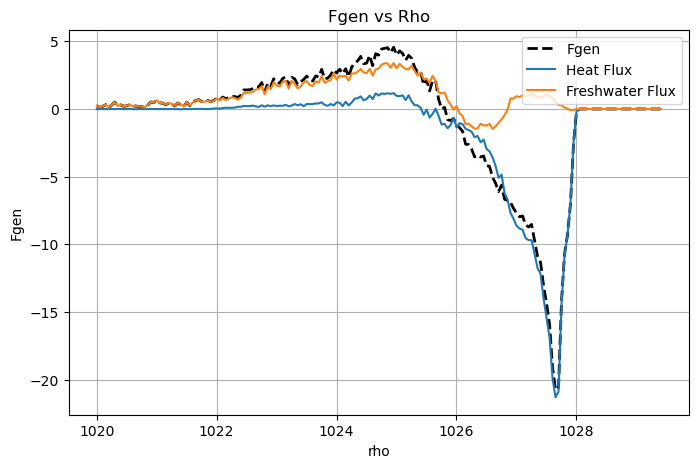

In [49]:
Fgen_clip = Fgen[(Fgen['rho'] >1020)]
plt.figure(figsize=(8,5))
plt.plot(Fgen_clip['rho'], Fgen_clip['Fgen'],'--', label = 'Fgen',  color='black', linewidth=2)
plt.plot(Fgen_clip['rho'], Fgen_clip['HeatFlux'], label='Heat Flux')
plt.plot(Fgen_clip['rho'], Fgen_clip['FreshwaterFlux'], label='Freshwater Flux')

plt.xlabel('rho')
plt.ylabel('Fgen')
plt.title('Fgen vs Rho')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

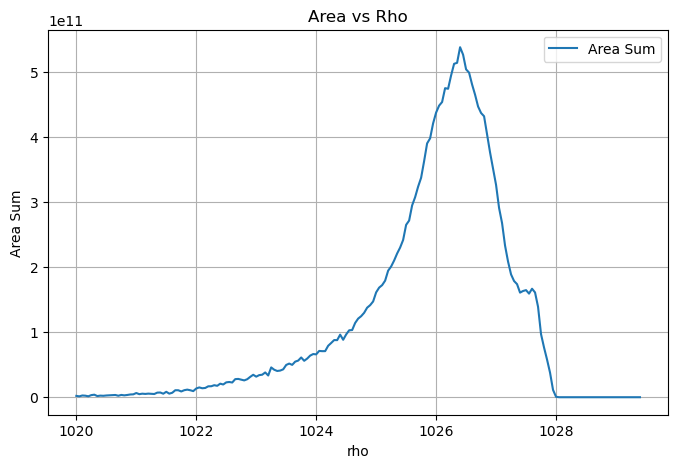

In [54]:
Fgen_clip = Fgen[(Fgen['rho'] >1020)]
plt.figure(figsize=(8,5))
plt.plot(Fgen_clip['rho'], Fgen_clip['AreaSum'], label = 'Area Sum')

plt.xlabel('rho')
plt.ylabel('Area Sum')
plt.title('Area vs Rho')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [55]:
save_path = f"/glade/work/stevenxu/AMOC_models/CESM1_Fgen.pkl"
with open(save_path, "wb") as f:
    pickle.dump(Fgen, f)